In [36]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [37]:
train = np.loadtxt('data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('data/digit/test.csv', delimiter=',', skiprows=1)

In [38]:
# сохраним разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обработки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

# Визуализируем исходные данные


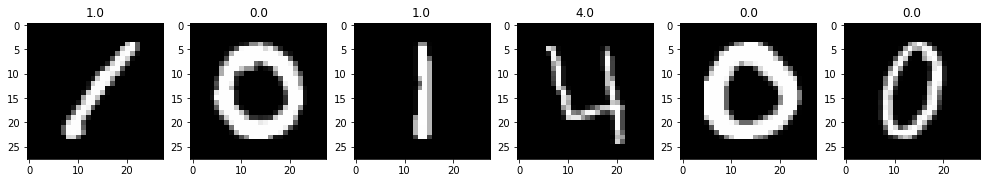

In [39]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:6], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

# Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [40]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range (len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3) 

# Вычисляем угол и длину вектора градиента

In [41]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

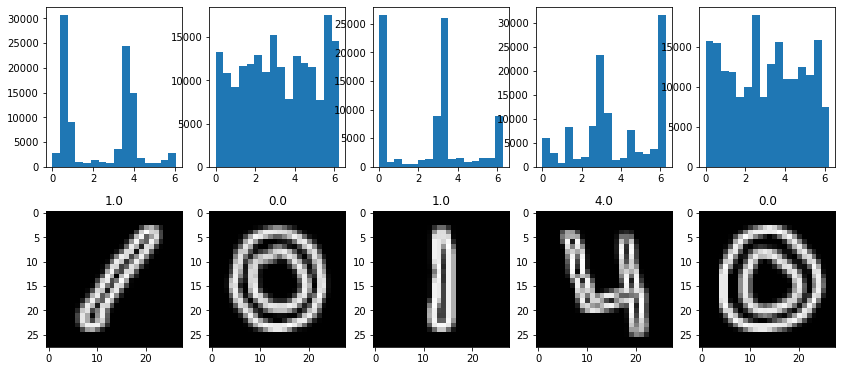

In [42]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i-1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i-1].flatten(),
             bins=16, weights=train_g[i-1].flatten())
    

# Вычисляем гистограммы градиентов c учетом длины вектора градиента

In [43]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                bins=16,
                                range=(0., 2. * np.pi),
                                weights=train_g[i])
    train_hist[i] = hist

In [44]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                bins=16,
                                range=(0., 2.0 * np.pi),
                                weights=test_g[i])
    test_hist[i] = hist

## Нормируем вектор гистограммы

In [45]:
# Пр умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [46]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

In [47]:
train_hist

array([[0.08965269, 0.68588233, 0.12990967, ..., 0.02192316, 0.0260756 ,
        0.04271804],
       [0.26896544, 0.23188415, 0.17378102, ..., 0.10979111, 0.37961404,
        0.26597783],
       [0.67357271, 0.02219091, 0.0335469 , ..., 0.03811633, 0.03691971,
        0.22548785],
       ...,
       [0.2594731 , 0.55008918, 0.07538063, ..., 0.04580354, 0.08201378,
        0.09829319],
       [0.26542906, 0.50419744, 0.24270852, ..., 0.04619964, 0.1262904 ,
        0.05680334],
       [0.45727184, 0.24947116, 0.34709528, ..., 0.11494278, 0.11435207,
        0.16776124]])

In [48]:
test_hist

array([[0.70710678, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.70710678, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.70710678, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.70710678, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.70710678, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.70710678, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

# Разбиваем выборку на обучение и валидацию

In [49]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=.2, random_state=42)

# Собираем полносвязную сеть для обучения

In [50]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8844935698206361440
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4850712576
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16445964830608026320
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:03:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


In [51]:
import tensorflow as tf    
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam

model = Sequential()

model.add(tf.keras.layers.Dense(32, 
                             input_dim=x_train.shape[1],
                             activation='relu'
                            ))
model.add(tf.keras.layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [52]:
x_train.shape[1]

16

In [53]:
16 * 32 + 32

544

# Выводим информацию о модели

In [54]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 32)                544       
                                                                 
 dense_3 (Dense)             (None, 10)                330       
                                                                 
Total params: 874
Trainable params: 874
Non-trainable params: 0
_________________________________________________________________


# One hot encoding разметки

In [55]:
y_train.shape

(33600,)

In [56]:
from keras.utils import np_utils
y_train_labels = np_utils.to_categorical(y_train)

In [57]:
y_train_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# Запускаем обучение

In [58]:
# Run training on GPU
with tf.device('/device:gpu:0'):
    model.fit(x_train, y_train_labels,
              batch_size=32, validation_split=.2,
              epochs=10)

Epoch 1/10
840/840 [==============================] - 6s 6ms/step - loss: 1.8018 - accuracy: 0.3586 - val_loss: 1.5013 - val_accuracy: 0.4644
Epoch 2/10
840/840 [==============================] - 5s 6ms/step - loss: 1.4123 - accuracy: 0.4973 - val_loss: 1.3618 - val_accuracy: 0.5158
Epoch 3/10
840/840 [==============================] - 5s 6ms/step - loss: 1.3084 - accuracy: 0.5415 - val_loss: 1.2783 - val_accuracy: 0.5501
Epoch 4/10
840/840 [==============================] - 5s 6ms/step - loss: 1.2420 - accuracy: 0.5658 - val_loss: 1.2211 - val_accuracy: 0.5741
Epoch 5/10
840/840 [==============================] - 5s 6ms/step - loss: 1.1993 - accuracy: 0.5790 - val_loss: 1.1909 - val_accuracy: 0.5815
Epoch 6/10
840/840 [==============================] - 5s 6ms/step - loss: 1.1729 - accuracy: 0.5853 - val_loss: 1.1717 - val_accuracy: 0.5857
Epoch 7/10
840/840 [==============================] - 5s 6ms/step - loss: 1.1537 - accuracy: 0.5935 - val_loss: 1.1511 - val_accuracy: 0.5888
Epoch 

# Предсказываем класс объекта

In [59]:
from sklearn.linear_model import LogisticRegression

In [60]:
predict_x=model.predict(x_val) 
classes_x=np.argmax(predict_x,axis=1)

263/263 [==============================] - 1s 2ms/step


In [61]:
# Run inference on CPU
with tf.device('/gpu:0'):
    pred_proba = model.predict(x_val)

263/263 [==============================] - 1s 2ms/step


In [62]:
predict_classes=np.argmax(pred_proba,axis=1)

In [63]:
predict_classes[:3]

array([8, 1, 4], dtype=int64)

In [64]:
pred_proba[:3]

array([[3.3341059e-01, 5.2631276e-05, 4.9641249e-03, 5.5071558e-03,
        2.5776973e-02, 6.2152365e-04, 2.2835815e-01, 1.0827766e-03,
        3.7041572e-01, 2.9810347e-02],
       [2.3739728e-06, 9.8549139e-01, 1.7762854e-07, 6.6172812e-10,
        1.0279994e-02, 5.6093894e-09, 1.5774222e-05, 4.0708259e-03,
        3.3191917e-08, 1.3945649e-04],
       [5.5943946e-03, 5.5758320e-03, 7.0090778e-03, 2.2549280e-04,
        4.4729897e-01, 2.8440212e-05, 2.7849758e-02, 7.2838873e-02,
        2.8903721e-04, 4.3329015e-01]], dtype=float32)

# Оцениваем качество решения на валидационной выборке

In [65]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, predict_classes))

Accuracy: 0.5971428571428572


In [66]:
from sklearn.metrics import classification_report
print(classification_report(y_val, predict_classes))

              precision    recall  f1-score   support

         0.0       0.39      0.19      0.25       816
         1.0       0.93      0.96      0.94       909
         2.0       0.44      0.41      0.42       846
         3.0       0.67      0.63      0.65       937
         4.0       0.65      0.63      0.64       839
         5.0       0.55      0.64      0.59       702
         6.0       0.40      0.46      0.43       785
         7.0       0.80      0.77      0.79       893
         8.0       0.45      0.61      0.52       835
         9.0       0.59      0.62      0.61       838

    accuracy                           0.60      8400
   macro avg       0.59      0.59      0.58      8400
weighted avg       0.59      0.60      0.59      8400



In [67]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, predict_classes))

[[153   9  77  16  41  30 214   5 226  45]
 [  0 870   1   0  25   0   2   4   1   6]
 [ 22   0 344 108   4 142  54  34 116  22]
 [ 15   0 116 589   0 111   4   2  87  13]
 [ 13  37   6   2 530   0 100  44   9  98]
 [  2   0  77 101   0 449  10  10  48   5]
 [ 80   3  73   9  72  10 359  14  95  70]
 [  4  12  25   2  45  13  35 691   7  59]
 [ 81   0  31  43   8  56  57   8 509  42]
 [ 24   3  35  10  88   5  67  51  33 522]]


## Предсказания на тестовыйх данных

In [68]:
pred_test = model.predict(test_hist)

875/875 [==============================] - 2s 2ms/step


## Визуализируем предсказания

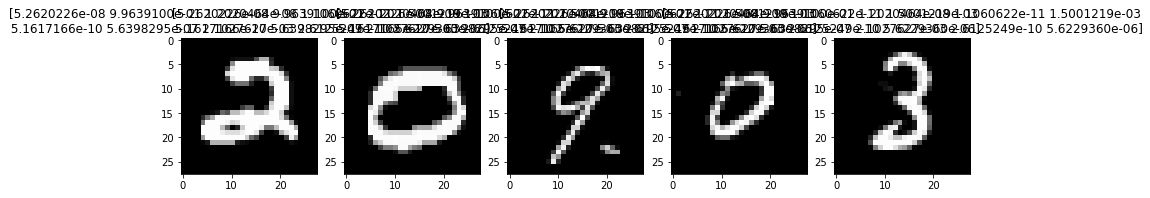

In [69]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

## Готовим файл для отправки

In [70]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))